# PDAML Report: Parameter Estimation

Everything is displayed and there is no need to re-run this notebook but please note that if you do choose to, occasionally minuit reaches max number of function calls and doesn't fully minimise but it is quick to run so can just re-run again. Thanks.

In [92]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from iminuit import Minuit

In [93]:
# nominal values from description
tau_true = 1.5
V_true = 0.1
delta_m_true = 20.0

- $\tau$ is called tau
- $V$ is called V
- $\Delta m$ is called delta_m

We note that the overall lifetime scale of the decay is determined by $\tau$ while the amplitude and wavelength of the oscillations are determined by $V$ and $\Delta m$ respectively.

## Part 1: Estimating statistical precision

1. Use toy Monte Carlo to generate datasets of decay times sampled from $P(t|V, \tau, \Delta m,)\propto (1+Vsin(\Delta mt))exp(\frac{-t}{\tau})$
    - $(i)$ for 10000 events
    - $(ii)$ for 100000 events
1. Carry out maximum likelihood fits on each dataset to get parameter best estimates and statistical errors (precision) for $\tau$, $V$ \& $\Delta m$

In [94]:
# return value of function for given time(s) not normalised
def simple_func(t, tau, V, delta_m):
    return (1.0 + V*np.sin(delta_m*t))*np.exp(-(t/tau))

# return value from normalised function
def simple_pdf(t, tau, V, delta_m):
    func = simple_func(t, tau, V, delta_m)
    # normalise numerically, can assume ~0 events appear beyond t=20 to use this instead of np.inf to speed up
    norm = quad(simple_func, 0, 20, args=(tau, V, delta_m))[0]
    # for taking log in nll later, need to overwrite any zero or negative probabilities with a tiny number
    for i in range(len(func)):
        if func[i] <= 0:
            func[i] = 1e-9
    return (1./norm) * func

# return toy dataset of specified number of events by Monte Carlo using box method from lecture 7
def MC_samples(tau, V, delta_m, num_events):
    # calc normalisation explicitly so only has to be done once not every time we would call simple_pdf()
    norm_true = quad(simple_func, 0, 20, args=(tau, V, delta_m))[0]
    # pdf greatest at t=0 so sets top of box
    f_max = (1./norm_true) * simple_func(0, tau,  V, delta_m)
    t_max = 20.
    samples = []
    while len(samples) < num_events:
        # candidate decay time from uniform distribution
        x1 = t_max * np.random.uniform()
        # probability it is accepted into samples
        y1 = (1./norm_true) * simple_func(x1, tau,  V, delta_m)
        y2 = f_max * np.random.uniform()
        if y2 < y1:
            samples.append(x1)
    return np.array(samples)

# return negative log-likelihood for given set of parameters, equivalent to maximising likelihood
def simple_nll1(tau, V, delta_m):
    pdf = simple_pdf(ts1, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

# same for second dataset
def simple_nll2(tau, V, delta_m):
    pdf = simple_pdf(ts2, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [95]:
# cases (i) and (ii) from description
num_events1 = 1e4
num_events2 = 1e5

In [96]:
# generate datasets
ts1 = MC_samples(tau_true, V_true, delta_m_true, num_events1)
ts2 = MC_samples(tau_true, V_true, delta_m_true, num_events2)

In [97]:
# fit with minutuit given reasonable initial guesses
fit1 = Minuit(simple_nll1, tau=1.2, V=0.2, delta_m=22.)
# definition of error for nll given in notes
fit1.errordef = 0.5
fit1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.396e+04                  │              Nfcn = 54               │
│ EDM = 0.000413 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.486   │   0.015   │            │            │         │         │       │
│ 1 │ V       │  -0.002   │   0.014   │            │            │         │         │       │
│ 2 │ delta_m │   21.2    │    0.5    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │      tau        V  delta_m │
├─────────┼────────────────────────────┤
│     tau │ 0.000221 9.56e-06  8.6e-06 │
│       V │ 9.56e-06 0.000204 0.000207 │
│ delta_m │  8.6e-06 0.000207    0.291 │
└─────────┴────────────────────────────┘

In [98]:
# same for second dataset
fit2 = Minuit(simple_nll2, tau=1.2, V=0.2, delta_m=22.)
# definition of error for nll given in notes
fit2.errordef = 0.5
fit2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.398e+05                  │              Nfcn = 100              │
│ EDM = 3.94e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.498   │   0.005   │            │            │         │         │       │
│ 1 │ V       │   0.105   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │  19.977   │   0.019   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  2.25e-05  9.99e-07 -1.21e-07 │
│       V │  9.99e-07  2.02e-05 -5.72e-07 │
│ delta_m │ -1.21e-07 -5.72e-07  0.000361 │
└─────────┴───────────────────────────────┘

In [99]:
# parameter best estimates and errors for (i)
tau_fit1 = fit1.values["tau"]
V_fit1 = fit1.values["V"]
delta_m_fit1 = fit1.values["delta_m"]
tau_fit1_error = fit1.errors["tau"]
V_fit1_error = fit1.errors["V"]
delta_m_fit1_error = fit1.errors["delta_m"]

# parameter best estimates and errors for (ii)
tau_fit2 = fit2.values["tau"]
V_fit2 = fit2.values["V"]
delta_m_fit2 = fit2.values["delta_m"]
tau_fit2_error = fit2.errors["tau"]
V_fit2_error = fit2.errors["V"]
delta_m_fit2_error = fit2.errors["delta_m"]

In [100]:
# plot a normalised histogram and overlay best fit curve
def plot_fit(samples, tau_fit, V_fit, delta_m_fit, name, ax):
    # plot histogram of data with name to display
    counts, bin_edges, _ = ax.hist(samples, bins=500, density=True, label=name+' data')
    # to evaluate function over centre of each bin
    tot_bin_edges = np.array(bin_edges)
    half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
    bin_centres = (tot_bin_edges + half_bin_width)[:-1]
    # plot best fit curve
    ax.plot(bin_centres, simple_pdf(bin_centres, tau_fit, V_fit, delta_m_fit), label=name+' fit')
    # for visualisation cut off after t=8
    ax.set_xlim(0, 8)
    ax.legend(loc="best")

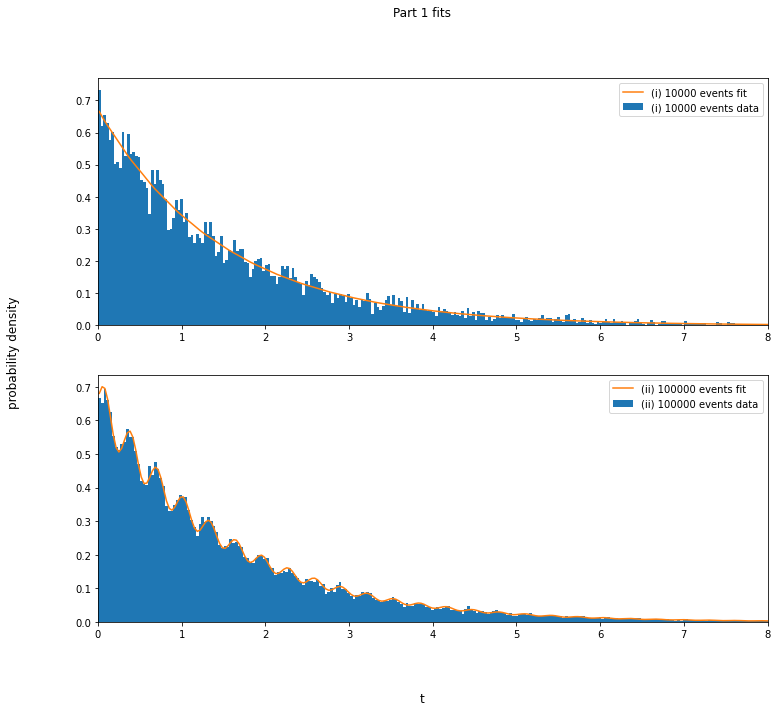

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.suptitle('Part 1 fits')
fig.supxlabel('t')
fig.supylabel('probability density')
plot_fit(ts1, tau_fit1, V_fit1, delta_m_fit1, '(i) 10000 events', axs[0])
plot_fit(ts2, tau_fit2, V_fit2, delta_m_fit2, '(ii) 100000 events', axs[1])
plt.show()

Both fits look relatively good. We see that having more events in the sample distribution better reconstructs the parent distribution given by exact pdf. Hence, peaks in the second datset are more sharply defined so the second fit is able to capture these oscillations better while in the first case, the random noise means minuit just treats this data almost like noisy exponential decay.

Note that by eye, the first histogram does appear to have oscillations and sometimes minuit would do better or worse at fitting to them but in this particular case has failed to capture them which was common when retrying with different MC data. The second fit with 100000 nearly always captured the oscillations well.

In [102]:
print('Statistical errors on fits\n')
print('(i) fitting to distribution of 10000 events:')
print('tau = {}, (statistical error on tau) = {}'.format(tau_fit1, tau_fit1_error))
print('V = {}, (statistical error on V) = {}'.format(V_fit1, V_fit1_error))
print('delta_m = {}, (statistical error on delta_m) = {}\n'.format(delta_m_fit1, delta_m_fit1_error))
print('(ii) fitting to distribution of 100000 events:')
print('tau = {}, (statistical error on tau) = {}'.format(tau_fit2, tau_fit2_error))
print('V = {}, (statistical error on V) = {}'.format(V_fit2, V_fit2_error))
print('delta_m = {}, (statistical error on delta_m) = {}'.format(delta_m_fit2, delta_m_fit2_error))

Statistical errors on fits

(i) fitting to distribution of 10000 events:
tau = 1.4860733746759838, (statistical error on tau) = 0.014876736168997281
V = -0.00229664939999049, (statistical error on V) = 0.014278394587458849
delta_m = 21.242792615357338, (statistical error on delta_m) = 0.5398850674561697

(ii) fitting to distribution of 100000 events:
tau = 1.497897490171915, (statistical error on tau) = 0.004742742178285043
V = 0.10530278658306585, (statistical error on V) = 0.004491981454997261
delta_m = 19.977032222922492, (statistical error on delta_m) = 0.018999412357711336


Quoting errors to 2 significant figures for (i), 10000 events , gives:
- $\tau = 1.486\pm 0.015$
- $V = -0.002\pm 0.014$
- $\Delta m = 19.98\pm 0.54$

And for (ii), 100000 events:
- $\tau = 1.4978\pm 0.0047$
- $V = 0.1053\pm 0.0045$
- $\Delta m = 19.977\pm 0.019$

The lifetime $\tau$ of the decay is accurately estimated for both cases but more precisely in the second case of (ii) 100000 events. We see greater precision on $\Delta m$ and greater accuracy and precision on $V$ and when fitting to the second case. This is expected as taking more samples smoothes out noise and better reconstructs the oscillations of the parent distribution. For (ii), all three parameter best estimates are within one-two error bars of their true value so 100000 events is a good sample size if this were a real experiment.

Note that with $V\approx 0$ as in the first fit, there are no oscillations. This means the value of $\Delta m$ is irrelevant so the first fit claiming to have accurately determined $\Delta m$ may not be reliable. 

## Part 2: Estimating possible bias due to time resolution

1. Use toy Monte Carlo to generate new dataset of true decay times sampled from $P(t|V, \tau, \Delta m,)\propto (1+Vsin(\Delta mt))exp(\frac{-t}{\tau})$ then each measurement is Gaussian distributed around the true decay time with $\sigma = f\tau$ to introduce time resolution (random error) in decay time measurements.
    - for $f = 0.01$
    - for $f = 0.03$
1. Carry out maximum likelihood fits on each dataset using true pdf unknowing of the time resolution effect

In [103]:
# returns toy Monte Carlo samples including time resolution
def tres_MC_samples(tau, V, delta_m, num_events, f):
    # get a dataset of true times
    ttrue_samples = MC_samples(tau, V, delta_m, num_events)
    sigma = f * tau
    # sample each from Gaussian centred on true time with sigma determined by f
    tres_samples = np.random.normal(ttrue_samples, sigma)
    return tres_samples

# pdf is unchanged from part 1
def simple_nll3(tau, V, delta_m):
    pdf = simple_pdf(ts3, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

def simple_nll4(tau, V, delta_m):
    pdf = simple_pdf(ts4, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [104]:
# two cases
f1 = 0.01
f2 = 0.03

In [105]:
# two datasets including time resolution, both have 10000 events
ts3 = tres_MC_samples(tau_true, V_true, delta_m_true, num_events1, f1)
ts4 = tres_MC_samples(tau_true, V_true, delta_m_true, num_events1, f2)

In [106]:
fit3 = Minuit(simple_nll3, tau=1.2, V=0.2, delta_m=22.)
fit3.errordef = 0.5
fit3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.411e+04                  │              Nfcn = 90               │
│ EDM = 4.49e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.507   │   0.015   │            │            │         │         │       │
│ 1 │ V       │  -0.033   │   0.014   │            │            │         │         │       │
│ 2 │ delta_m │   17.57   │   0.12    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │      tau        V  delta_m │
├─────────┼────────────────────────────┤
│     tau │ 0.000228 1.14e-05 4.15e-06 │
│       V │ 1.14e-05   0.0002 4.48e-05 │
│ delta_m │ 4.15e-06 4.48e-05    0.015 │
└─────────┴────────────────────────────┘

In [107]:
fit4 = Minuit(simple_nll4, tau=1.2, V=0.2, delta_m=22.)
fit4.errordef = 0.5
fit4.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.4e+04                    │              Nfcn = 161              │
│ EDM = 3.17e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.495   │   0.015   │            │            │         │         │       │
│ 1 │ V       │   0.049   │   0.014   │            │            │         │         │       │
│ 2 │ delta_m │   20.17   │   0.10    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  0.000224  9.99e-06 -2.19e-06 │
│       V │  9.99e-06  0.000203  -1.8e-05 │
│ delta_m │ -2.19e-06  -1.8e-05    0.0108 │
└─────────┴───────────────────────────────┘

In [108]:
# parameter best estimates and errors for f=0.01
tau_fit3 = fit3.values["tau"]
V_fit3 = fit3.values["V"]
delta_m_fit3 = fit3.values["delta_m"]
tau_fit3_error = fit3.errors["tau"]
V_fit3_error = fit3.errors["V"]
delta_m_fit3_error = fit3.errors["delta_m"]

# parameter best estimates and errors for f=0.03
tau_fit4 = fit4.values["tau"]
V_fit4 = fit4.values["V"]
delta_m_fit4 = fit4.values["delta_m"]
tau_fit4_error = fit4.errors["tau"]
V_fit4_error = fit4.errors["V"]
delta_m_fit4_error = fit4.errors["delta_m"]

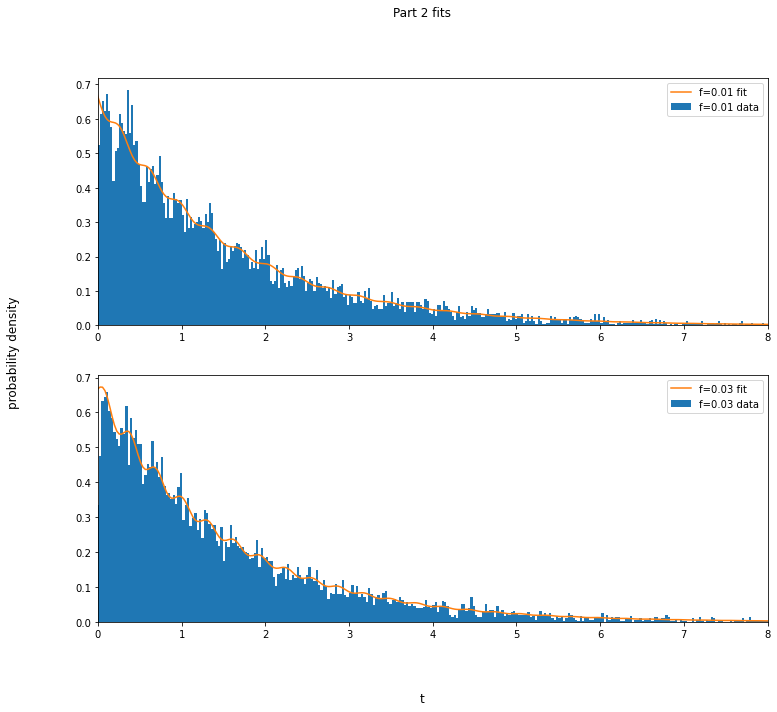

In [109]:
# same kind of plot as before
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.suptitle('Part 2 fits')
fig.supxlabel('t')
fig.supylabel('probability density')
plot_fit(ts3, tau_fit3, V_fit3, delta_m_fit3, 'f=0.01', axs[0])
plot_fit(ts4, tau_fit4, V_fit4, delta_m_fit4, 'f=0.03', axs[1])
plt.show()

We can see the added time resolution effect smoothes out the already noisy oscillations of a 10000 event dataset. Neither of the fits capture the oscillations particularly well but the overall lifetime scale is well fitted to both from visual inspection. We also see that with the poorest time resolution case of $f=0.03$, oscillations are not really visible anymore.

In [122]:
print('Bias on fit parameters introduced by including resolution effect\n')
print('f = 0.01')
print('(bias on tau) = {}, expected statistical error was {}'.format(tau_fit3 - tau_fit1, tau_fit1_error))
print('(bias on V) = {}, expected statistical error was {}'.format(V_fit3 - V_fit1, V_fit1_error))
print('(bias on delta_m) = {}, expected statistical error was {}\n'.format(delta_m_fit3 - delta_m_fit1, delta_m_fit1_error))
print('f = 0.03')
print('(bias on tau) = {}, expected statistical error was {}'.format(tau_fit4 - tau_fit1, tau_fit1_error))
print('(bias on V) = {}, expected statistical error was {}'.format(V_fit4 - V_fit1, V_fit1_error))
print('(bias on delta_m) = {}, expected statistical error was {}'.format(delta_m_fit4 - delta_m_fit1, delta_m_fit1_error))

Bias on fit parameters introduced by including resolution effect

f = 0.01
(bias on tau) = 0.020860045785210835, expected statistical error was 0.014876736168997281
(bias on V) = -0.031191473029774645, expected statistical error was 0.014278394587458849
(bias on delta_m) = -3.676781630255288, expected statistical error was 0.5398850674561697

f = 0.03
(bias on tau) = 0.00866381041134523, expected statistical error was 0.014876736168997281
(bias on V) = 0.05160823785624659, expected statistical error was 0.014278394587458849
(bias on delta_m) = -1.0702792269698769, expected statistical error was 0.5398850674561697


For both $f=0.01$ and $f=0.03$
- The $0.015$ expected statistical error on $\tau$ from part 1 is comparable to the bias on $\tau$ of 0.02 introduced by time resolution effects. Therefore, this difference between experiments is statistically expected and not necessarily due to time resolution effects. This is expected because $\tau$ determined the overall lifetime scale of the decay which should not be affected by time resolution for a large enough sample size.
- The $0.014$ and $0.12$ expected statistical errors on $V$ and $\Delta m$ repectively were only fractions of the biases on $V$ and $\Delta m$ so the time resolution effect cannot be ignored when estimating $V$ and $\Delta m$ as it is unlikely that these deviations are purely statistical. This is expected because these parameters determine the oscillations which do get more noisy with increasing f so we expect fitting $V$ and $\Delta m$ to be less accurate than in part 1.

Note that the first bullet point should stand as $\tau$ was accurately estimated in part 1 for the 10000 event data. However, the second bullter point about $V$ and $\Delta m$ shows what we expect but may be a fluke as $V$ and $\Delta m$ were not accurately estimated in part 1 for the 10000 event data. The task specifies to use this data but perhaps I could try different minimisers to get a better fit in part 1. Deviating from the task, I carried out identical analysis but for the 100000 events data for which we do have an accurate fit for all three parameters in part 1.

In [123]:
def simple_nll_extra1(tau, V, delta_m):
    pdf = simple_pdf(ts_extra1, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

def simple_nll_extra2(tau, V, delta_m):
    pdf = simple_pdf(ts_extra2, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [127]:
# two datasets including time resolution, both have 100000 events this time
ts_extra1 = tres_MC_samples(tau_true, V_true, delta_m_true, num_events2, f1)

In [131]:
ts_extra2 = tres_MC_samples(tau_true, V_true, delta_m_true, num_events2, f2)

In [128]:
fit_extra1 = Minuit(simple_nll_extra1, tau=1.2, V=0.2, delta_m=22.)
fit_extra1.errordef = 0.5
fit_extra1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.402e+05                  │              Nfcn = 137              │
│ EDM = 1.62e-08 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.501   │   0.005   │            │            │         │         │       │
│ 1 │ V       │   0.081   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │  19.983   │   0.025   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  2.26e-05  9.98e-07 -1.62e-07 │
│       V │  9.98e-07  2.01e-05 -7.82e-07 │
│ delta_m │ -1.62e-07 -7.82e-07  0.000621 │
└─────────┴───────────────────────────────┘

In [132]:
fit_extra2 = Minuit(simple_nll_extra2, tau=1.2, V=0.2, delta_m=22.)
fit_extra2.errordef = 0.5
fit_extra2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.404e+05                  │              Nfcn = 149              │
│ EDM = 9.07e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.496   │   0.005   │            │            │         │         │       │
│ 1 │ V       │  -0.029   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │   22.88   │   0.07    │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬────────────────────────────┐
│         │      tau        V  delta_m │
├─────────┼────────────────────────────┤
│     tau │ 2.24e-05 8.75e-07 6.19e-07 │
│       V │ 8.75e-07    2e-05 7.69e-06 │
│ delta_m │ 6.19e-07 7.69e-06  0.00526 │
└─────────┴────────────────────────────┘

In [133]:
# parameter best estimates and errors for f=0.01
tau_fit_extra1 = fit_extra1.values["tau"]
V_fit_extra1 = fit_extra1.values["V"]
delta_m_fit_extra1 = fit_extra1.values["delta_m"]
tau_fit_extra1_error = fit_extra1.errors["tau"]
V_fit_extra1_error = fit_extra1.errors["V"]
delta_m_fit_extra1_error = fit_extra1.errors["delta_m"]

# parameter best estimates and errors for f=0.03
tau_fit_extra2 = fit_extra2.values["tau"]
V_fit_extra2 = fit_extra2.values["V"]
delta_m_fit_extra2 = fit_extra2.values["delta_m"]
tau_fit_extra2_error = fit_extra2.errors["tau"]
V_fit_extra2_error = fit_extra2.errors["V"]
delta_m_fit_extra2_error = fit_extra2.errors["delta_m"]

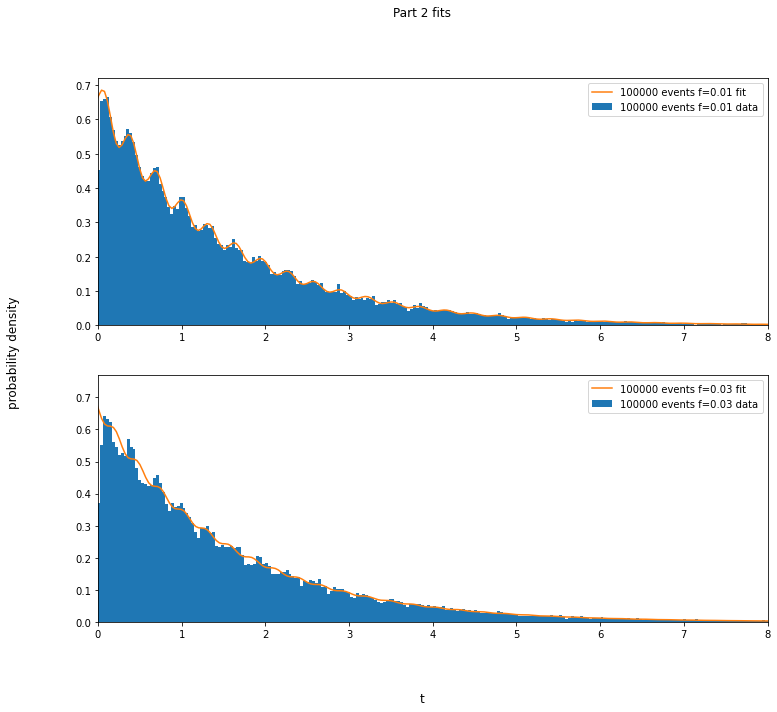

In [134]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))
fig.suptitle('Part 2 extra fits')
fig.supxlabel('t')
fig.supylabel('probability density')
plot_fit(ts_extra1, tau_fit_extra1, V_fit_extra1, delta_m_fit_extra1, '100000 events f=0.01', axs[0])
plot_fit(ts_extra2, tau_fit_extra2, V_fit_extra2, delta_m_fit_extra2, '100000 events f=0.03', axs[1])
plt.show()

The second fit for $f=0.03$ still quite poorly captures the oscillations due to time resolution but for the less severe time resolution effect of $f=0.01$ above it, the oscillations are well captured like in part 1.

In [136]:
print('Bias on fit parameters introduced by including resolution effect for 100000 events dataset\n')
print('f = 0.01')
print('(bias on tau) = {}, expected statistical error was {}'.format(tau_fit_extra1 - tau_fit2, tau_fit2_error))
print('(bias on V) = {}, expected statistical error was {}'.format(V_fit_extra1 - V_fit2, V_fit2_error))
print('(bias on delta_m) = {}, expected statistical error was {}\n'.format(delta_m_fit_extra1 - delta_m_fit2, delta_m_fit2_error))
print('f = 0.03')
print('(bias on tau) = {}, expected statistical error was {}'.format(tau_fit_extra2 - tau_fit2, tau_fit2_error))
print('(bias on V) = {}, expected statistical error was {}'.format(V_fit_extra2 - V_fit2, V_fit2_error))
print('(bias on delta_m) = {}, expected statistical error was {}'.format(delta_m_fit_extra2 - delta_m_fit2, delta_m_fit2_error))

Bias on fit parameters introduced by including resolution effect for 100000 events dataset

f = 0.01
(bias on tau) = 0.0033419615874792363, expected statistical error was 0.004742742178285043
(bias on V) = -0.02420020227036601, expected statistical error was 0.004491981454997261
(bias on delta_m) = 0.0056113083252640195, expected statistical error was 0.018999412357711336

f = 0.03
(bias on tau) = -0.0016541917641457182, expected statistical error was 0.004742742178285043
(bias on V) = -0.13387161130598976, expected statistical error was 0.004491981454997261
(bias on delta_m) = 2.902845068297541, expected statistical error was 0.018999412357711336


Now we can confirm our earlier suspicions that the deviations in $\tau$ could be purely statistical and possible bias from including time resolution effects could be ignored. However, for $V$ and $\Delta m$, the bias is significant compared to the statistical errors especially in the more severe case of $f=0.03$ as expected.

## Part 3: Estimating a systematic error due to time acceptance

1. Simulate time acceptance of $a=1+st$ in MC data by sampling $s$ from Gaussian with mean 0 and standard deviation 0.03.
1. Carry out three fits on this data each with their own fixed $s$:
    - first for $s=0$, the best estimate for $s$
    - for $s=+0.03$
    - for $s=-0.03$
1. Take the average magnitude of shift in parameter best estimates of $\tau$, $V$ and $\Delta m$ from $s=0\rightarrow s=\pm 0.03$ as measure of systematic error

Note that since the task does not specify I have not included time resolution effects from part 2 and for all of part 3 have only used a dataset of 100000 events as that worked better in parts 1 and 2.

In [111]:
# return value of function including time acceptance
def tacc_func(t, tau, V, delta_m):
    # time acceptance function multiplies original function
    return (1 + s*t) * simple_func(t, tau, V, delta_m)

# return value from normalised function including time acceptance
def tacc_pdf(t, tau, V, delta_m):
    func = tacc_func(t, tau, V, delta_m)
    norm = quad(tacc_func, 0, 20, args=(tau, V, delta_m))[0]
    for i in range(len(func)):
        if func[i] <= 0:
            func[i] = 1e-9
    return (1./norm) * func

# return MC samples including time acceptance
def tacc_MC_samples(tau, V, delta_m, num_events):
    norm_true = quad(tacc_func, 0, 20, args=(tau, V, delta_m))[0]
    f_max = (1./norm_true) * tacc_func(0, tau,  V, delta_m)
    t_max = 20.
    samples = []
    while len(samples) < num_events:
        x1 = t_max * np.random.uniform()
        y1 = (1./norm_true) * tacc_func(x1, tau,  V, delta_m)
        y2 = f_max * np.random.uniform()
        if y2 < y1:
            samples.append(x1)
    return np.array(samples)

# return nll including time acceptance
def tacc_nll(tau, V, delta_m):
    pdf = tacc_pdf(ts5, tau, V, delta_m)
    nll = -1 * np.sum(np.log(pdf))
    return nll

In [112]:
# best estimate for s given in task
best_est_s = 0.
# error on s
s_precision = 0.03

In [137]:
# choose an s for generating data
s = np.random.normal(best_est_s, s_precision)
ts5 = tacc_MC_samples(tau_true, V_true, delta_m_true, num_events2)

In [138]:
# fit with s=0
s = best_est_s
fit5 = Minuit(tacc_nll, tau=1.2, V=0.2, delta_m=22.)
fit5.errordef = 0.5
fit5.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.298e+05                  │              Nfcn = 81               │
│ EDM = 5.09e-06 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.355   │   0.004   │            │            │         │         │       │
│ 1 │ V       │   0.098   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │  19.995   │   0.025   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  1.84e-05  9.98e-07 -1.84e-07 │
│       V │  9.98e-07  2.02e-05  -6.8e-07 │
│ delta_m │ -1.84e-07  -6.8e-07  0.000624 │
└─────────┴───────────────────────────────┘

In [139]:
# fit with s=+0.03
s = best_est_s + s_precision
fit6 = Minuit(tacc_nll, tau=1.2, V=0.2, delta_m=22.)
fit6.errordef = 0.5
fit6.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.298e+05                  │              Nfcn = 82               │
│ EDM = 6.14e-07 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.306   │   0.004   │            │            │         │         │       │
│ 1 │ V       │   0.098   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │  19.995   │   0.025   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  1.59e-05  9.28e-07 -1.71e-07 │
│       V │  9.28e-07  2.02e-05 -6.78e-07 │
│ delta_m │ -1.71e-07 -6.78e-07  0.000623 │
└─────────┴───────────────────────────────┘

In [140]:
# fit with s=-0.03
s = best_est_s - s_precision
fit7 = Minuit(tacc_nll, tau=1.2, V=0.3, delta_m=22.)
fit7.errordef = 0.5
fit7.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1.298e+05                  │              Nfcn = 80               │
│ EDM = 2.78e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ tau     │   1.418   │   0.005   │            │            │         │         │       │
│ 1 │ V       │   0.099   │   0.004   │            │            │         │         │       │
│ 2 │ delta_m │  19.995   │   0.025   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬───────────────────────────────┐
│         │       tau         V   delta_m │
├─────────┼───────────────────────────────┤
│     tau │  2.22e-05   1.1e-06 -2.02e-07 │
│       V │   1.1e-06  2.02e-05 -6.81e-07 │
│ delta_m │ -2.02e-07 -6.81e-07  0.000623 │
└─────────┴───────────────────────────────┘

In [141]:
# s=0
tau_fit5 = fit5.values["tau"]
V_fit5 = fit5.values["V"]
delta_m_fit5 = fit5.values["delta_m"]
tau_fit5_staterror = fit5.errors["tau"]
V_fit5_staterror = fit5.errors["V"]
delta_m_fit5_staterror = fit5.errors["delta_m"]

# s=+0.03
tau_fit6 = fit6.values["tau"]
V_fit6 = fit6.values["V"]
delta_m_fit6 = fit6.values["delta_m"]
tau_fit6_staterror = fit6.errors["tau"]
V_fit6_staterror = fit6.errors["V"]
delta_m_fit6_staterror = fit6.errors["delta_m"]

# s=-0.03
tau_fit7 = fit7.values["tau"]
V_fit7 = fit7.values["V"]
delta_m_fit7 = fit7.values["delta_m"]
tau_fit7_staterror = fit7.errors["tau"]
V_fit7_staterror = fit7.errors["V"]
delta_m_fit7_staterror = fit7.errors["delta_m"]

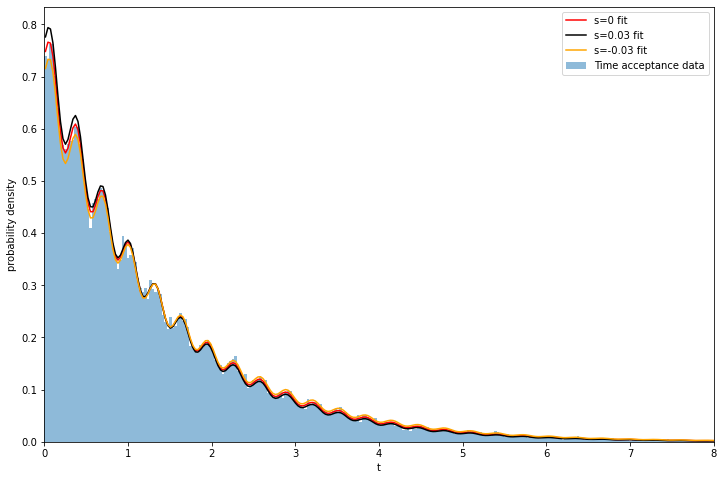

In [142]:
fig, ax = plt.subplots(figsize=(12,8))
# alpha changes opacity to make lines more visible
counts, bin_edges, _ = ax.hist(ts5, bins=500, density=True, label='Time acceptance data', alpha=0.5)
tot_bin_edges = np.array(bin_edges)
half_bin_width = (tot_bin_edges[1] - tot_bin_edges[0]) / 2.
bin_centres = (tot_bin_edges + half_bin_width)[:-1]
# this time plot all three fits on same axes as they fit to same dataset
ax.plot(bin_centres, simple_pdf(bin_centres, tau_fit5, V_fit5, delta_m_fit5), label='s=0 fit', color='red')
ax.plot(bin_centres, simple_pdf(bin_centres, tau_fit6, V_fit6, delta_m_fit6), label='s=0.03 fit', color='black')
ax.plot(bin_centres, simple_pdf(bin_centres, tau_fit7, V_fit7, delta_m_fit7), label='s=-0.03 fit', color='orange')
ax.set_xlabel('t')
ax.set_ylabel('probability density')
ax.set_xlim(0, 8)
ax.legend(loc="best")
plt.show()

In [143]:
# return estimate of systematic error for one parameter
def estimate_sys_error(param0, param1, param2):
    shift1 = abs(param1 - param0)
    shift2 = abs(param2 - param0)
    avg_shift = np.mean(np.array([shift1, shift2]))
    return avg_shift

In [144]:
tau_sys_error = estimate_sys_error(tau_fit5, tau_fit6, tau_fit7)
V_sys_error = estimate_sys_error(V_fit5, V_fit6, V_fit7)
delta_m_sys_error = estimate_sys_error(delta_m_fit5, delta_m_fit6, delta_m_fit7)

In [146]:
print('Systematic errors vs Statistical errors\n')
print('systematic error on tau = {}, statistical error was {}'.format(tau_sys_error, tau_fit5_staterror))
print('systematic error on V = {}, statistical error was {}'.format(V_sys_error, V_fit5_staterror))
print('systematic error on delta_m = {}, statistical error was {}'.format(delta_m_sys_error, delta_m_fit5_staterror))

Systematic errors vs Statistical errors

systematic error on tau = 0.05615449292159436, statistical error was 0.0042918953492815165
systematic error on V = 0.0001452387656008594, statistical error was 0.004492907495301404
systematic error on delta_m = 1.598327859575477e-05, statistical error was 0.02498129484528251


The same statistical errors for the fit using best estimate $s=0$ given to two significant figures:
- for $\tau$, statistical error was 0.0043. The systematic error is significant in comparison so cannot be ignored. This is expected as unlike for time resolution (part 2) multiplying by a linear time acceptance function alters the lifetime scale of an exponential-like decay
- for $V$, statistical error was 0.0045. The systematic error is insignificant in comparison so we could ignore time acceptance effects if purely interested in $V$
- for $\Delta m$, statistical error was 0.025. The systematic error is also insignificant in comparison. This is expected for $V$ and $\Delta m$ because this particular form of time acceptance function doesn't affect the nature of the oscillations much (especially their wavelength defined by $\Delta m$) like it does the lifetime scale $\tau$

